In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv

In [2]:
import os
print(os.listdir("input"))

['sample_submission.csv', 'test', 'train', 'train.csv']


In [3]:
# ! pip install pretrainedmodels

In [4]:
import os
import time
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from pretrainedmodels import xception

import PIL
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

import warnings

warnings.filterwarnings("ignore")

In [5]:
IMG_SIZE = 128
NUM_CHANNEL = 4

PATH_TO_IMAGES = 'input/train/'
PATH_TO_TEST_IMAGES = 'input/test/'
PATH_TO_META = 'input/train.csv'
SAMPLE_SUBMIT = 'input/sample_submission.csv'

SEED = 12
DEVICE = 'cuda'

LABEL_MAP = {
    0: "Nucleoplasm",
    1: "Nuclear membrane",
    2: "Nucleoli",
    3: "Nucleoli fibrillar center",
    4: "Nuclear speckles",
    5: "Nuclear bodies",
    6: "Endoplasmic reticulum",
    7: "Golgi apparatus",
    8: "Peroxisomes",
    9: "Endosomes",
    10: "Lysosomes",
    11: "Intermediate filaments",
    12: "Actin filaments",
    13: "Focal adhesion sites",
    14: "Microtubules",
    15: "Microtubule ends",
    16: "Cytokinetic bridge",
    17: "Mitotic spindle",
    18: "Microtubule organizing center",
    19: "Centrosome",
    20: "Lipid droplets",
    21: "Plasma membrane",
    22: "Cell junctions",
    23: "Mitochondria",
    24: "Aggresome",
    25: "Cytosol",
    26: "Cytoplasmic bodies",
    27: "Rods & rings"}


# Originally from https://www.kaggle.com/crimzoid/4-channel-resnet-from-scratch-pytorch-lb-0-16
# Modified by Ji Yang

image_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomChoice([
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomAffine((0, 0)),
        transforms.RandomAffine((90, 90)),
        transforms.RandomAffine((180, 180)),
        transforms.RandomAffine((270, 270)),
    ]),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

sub_image_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),

])


class MultiBandMultiLabelDataset(Dataset):
    # BANDS_NAMES = ['_red.png', '_green.png', '_blue.png']
    BANDS_NAMES = ['_red.png', '_green.png', '_blue.png', '_yellow.png']

    def __len__(self):
        return len(self.images_df)

    def __init__(self, images_df, base_path, image_transform, train_mode=True):
        if not isinstance(base_path, pathlib.Path):
            base_path = pathlib.Path(base_path)

        self.images_df = images_df.copy()
        self.image_transform = image_transform
        self.images_df.Id = self.images_df.Id.apply(lambda x: base_path / x)
        self.mlb = MultiLabelBinarizer(classes=list(LABEL_MAP.keys()))
        self.train_mode = train_mode

    def __getitem__(self, index):
        y = None
        X = self._load_multiband_image(index)
        if self.train_mode:
            y = self._load_multilabel_target(index)

        X = self.image_transform(X)

        return X, y

    def _load_multiband_image(self, index):
        row = self.images_df.iloc[index]
        image_bands = []
        for band_name in self.BANDS_NAMES:
            p = str(row.Id.absolute()) + band_name
            img = PIL.Image.open(p)
            image_bands.append(img)

        # lets pretend its a RBGA image to support 4 channels
        band4image = PIL.Image.merge('RGBA', bands=image_bands)

        return band4image

    def _load_multilabel_target(self, index):
        return list(map(int, self.images_df.iloc[index].Target.split(' ')))

    def collate_func(self, batch):
        labels = None
        images = [x[0] for x in batch]

        if self.train_mode:
            labels = [x[1] for x in batch]
            labels_one_hot = self.mlb.fit_transform(labels)
            labels = torch.FloatTensor(labels_one_hot)

        return torch.stack(images)[:, :4, :, :], labels


df = pd.read_csv(PATH_TO_META)
df_train, df_test = train_test_split(df, test_size=.1, random_state=SEED)
df_submission = pd.read_csv(SAMPLE_SUBMIT)

In [384]:
# debugging = True
# if debugging:
#     EPOCHS = 5
#     BATCH_SIZE = 24
#     BASE_LR = 0.001

# if debugging:
#       df_train = df_train[:2000]
# #     df_test = df_test[:50]
#         df_submission = df_submission
EPOCHS = 20
BASE_LR = 0.001
BATCH_SIZE = 128
gtrain = MultiBandMultiLabelDataset(df_train, base_path=PATH_TO_IMAGES, image_transform=image_transform)
train_load = DataLoader(gtrain, collate_fn=gtrain.collate_func, batch_size=BATCH_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

min: -1.0, max: 1.0


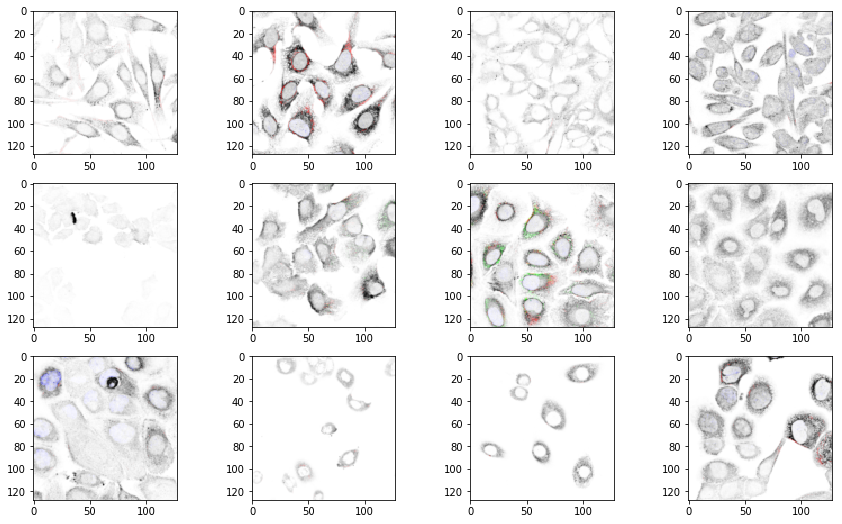

In [385]:
for batch_idx, batch in enumerate(train_load):
    break
images, labels = batch

fig, ax = plt.subplots(3, 4, figsize=(15, 9))
for r in range(3):
    for c in range(4):
        ax[r][c].imshow(images[r * 4 + c].permute(1, 2, 0))
print('min: {0}, max: {1}'.format(images.min(), images.max()))

In [386]:
w_in = 512
F = 4
P = 0
S = 1
w_in-F+2*P / S + 1

509.0

In [387]:
w_in = 499
F = 32
P = 1
S = 1
print((w_in-F+2*P) / S + 1)

470.0


In [388]:
470/2

235.0

In [389]:
w_in = 235
F = 32
P = 0
S = 1
print((w_in-F+2*P) / S + 1)

204.0


In [390]:
w_in = 102
F = 64
P = 0
S = 1
print((w_in-F+2*P) / S + 1)

39.0


In [391]:
39*64/2

1248.0

In [406]:
import torch.nn.functional as F
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.dense1_bn = nn.BatchNorm2d(4)  
        self.conv1 = nn.Conv2d(4, 8, 3)
        
        self.dense2_bn = nn.BatchNorm2d(8)       
        self.conv2 = nn.Conv2d(8, 16,3)
        
        self.dense3_bn = nn.BatchNorm2d(16) 
        self.conv3 = nn.Conv2d(16, 16,3)
        self.conv4 = nn.Conv2d(16, 16,3)
        self.conv5 = nn.Conv2d(16, 16,3)
        
        self.fc1   = nn.Linear(11664, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 28)
        

    def forward(self, x):
        
        out = self.dense1_bn(x)
        out = self.conv1(out)
        out = F.relu(out)
       # print(out)
        out = self.dense2_bn(out)
        out = self.conv2(out)
        out = F.relu(out)
        out = self.dense3_bn(out)
        out = self.conv3(out)
        out = F.relu(out)
        out = F.max_pool2d(out, 2)
        
        out = F.relu(self.conv4(out))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv5(out))
        
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        out = F.sigmoid(out)
        return out

In [407]:
class ConvBnRelu2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super().__init__()
        self.conv = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding),
                                  nn.BatchNorm2d(out_channels),
                                  nn.ReLU(inplace=True)
                                  )

    def forward(self, x):
        return self.conv(x)


class Xception(nn.Module):
    def __init__(self, num_classes=28, pretrained='imagenet', dropout_rate=0.3):
        super(Xception, self).__init__()
        self.pretrained_model = xception(pretrained=pretrained)
        self.process_input = nn.Sequential(
            ConvBnRelu2d(4, 16),
            ConvBnRelu2d(16, 3),
        )
        self.fc_input = 2048
        self.activation = nn.ReLU()
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.last_linear = nn.Linear(self.fc_input, num_classes)

    def forward(self, x):
        x = self.process_input(x)
        x = self.pretrained_model.features(x)
        x = self.activation(x)
        x = self.pooling(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.last_linear(x)
        return x

In [408]:
def f1_loss(target, output, epsilon=1e-7):
    y_pred = nn.Sigmoid()(output)
    y_true = target.double()

    TP = (y_pred * y_true).sum(1)
    prec = TP / (y_pred.sum(1) + epsilon)
    rec = TP / (y_true.sum(1) + epsilon)
    res = 2 * prec * rec / (prec + rec + epsilon)

    f1 = res
    f1 = f1.clamp(min=0)
    return 1 - f1.mean()


from sklearn.metrics import f1_score

sk_f1_score = f1_score


class AverageMeter:
    """Computes and stores the average and current value"""

    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def init(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __repr__(self):
        return str(self.avg)

In [409]:
EPOCHS, BATCH_SIZE, BASE_LR, DEVICE

(5, 128, 0.001, 'cuda')

In [410]:
torch.cuda.empty_cache()

In [ ]:
#model = Xception(num_classes=28, pretrained=None).to(DEVICE)
model = LeNet().to(DEVICE)
# for param in model.modules():
#     param.requires_grad = False

gtrain = MultiBandMultiLabelDataset(df_train, base_path=PATH_TO_IMAGES, image_transform=image_transform)
gtest = MultiBandMultiLabelDataset(df_test, base_path=PATH_TO_IMAGES, image_transform=image_transform)

train_load = DataLoader(gtrain, collate_fn=gtrain.collate_func, batch_size=BATCH_SIZE, shuffle=True)
test_load = DataLoader(gtest, collate_fn=gtest.collate_func, batch_size=BATCH_SIZE,shuffle=True)

criterion = nn.BCEWithLogitsLoss(reduction='sum')
lr = 1.0
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

patience = 0
best_validation = 0
record = []
val_record = []
lrs = []
EPOCHS = 5
for epoch in range(1, EPOCHS):
#     if epoch % 2 == 0:
#         lr *= 0.5
#         for param_group in optimizer.param_groups:
#             param_group['lr'] = lr
#             print('Epoch {} with starting LR {}\n'.format(epoch, lr))
#     lrs.append(lr)
    epoch_loss = AverageMeter()
    epoch_scr = AverageMeter()
    epoch_skl = AverageMeter()
    start = time.time()
    print(epoch)
    for batch_idx, batch in enumerate(train_load):
        optimizer.zero_grad()
        data_, target = batch
        data = data_.to(DEVICE)
        target = target.to(DEVICE)
        
        output = model(data)
        loss = criterion(target, output)
        loss.backward()
        
        # f1 = f1_score(target, output)
        f1 = sk_f1_score(target.cpu().data.numpy(), (output > 0.2).cpu().data.numpy(), average='macro')
        # sk_f1 = sk_f1_score(target.cpu().data.numpy(), (output > 0.5).cpu().data.numpy(), average='macro')
        
        
        
       # print(batch_idx)
        print(loss.item())
        print(output)
        optimizer.step()
        
        epoch_loss.update(loss.item())
        epoch_scr.update(f1)
        
    print('Epoch {:3} Trn --> Loss: {:.5f}, F1: {:.5f}'.format(epoch, epoch_loss.avg, epoch_scr.avg), end=' | ')
    record.append((epoch_loss, epoch_scr))

    with torch.no_grad():
        val_epoch_loss = AverageMeter()
        val_epoch_scr = AverageMeter()
        for batch_idx, batch in enumerate(test_load):
            data_, target = batch
            data = data_.to(DEVICE)
            target = target.to(DEVICE)
            output = model(data)
            loss = f1_loss(target.double(), output.double())
            f1 = sk_f1_score(target.cpu().data.numpy(), (output > 0.5).cpu().data.numpy(), average='macro')
            val_epoch_loss.update(loss.item())
            val_epoch_scr.update(f1)
        print('Epoch {:3} Val --> Loss: {:.5f}, F-1: {:.5f}'.format(epoch, val_epoch_loss.avg, val_epoch_scr.avg),
              end=' | \n')
        val_record.append((val_epoch_loss, val_epoch_scr))
        model.train()
        

1
2510.645263671875
tensor([[0.4757, 0.5047, 0.4926,  ..., 0.5047, 0.4639, 0.5126],
        [0.4768, 0.5046, 0.4938,  ..., 0.5046, 0.4642, 0.5136],
        [0.4758, 0.5052, 0.4931,  ..., 0.5048, 0.4636, 0.5120],
        ...,
        [0.4780, 0.5038, 0.4941,  ..., 0.5060, 0.4660, 0.5132],
        [0.4771, 0.5015, 0.4924,  ..., 0.5054, 0.4614, 0.5124],
        [0.4771, 0.5042, 0.4936,  ..., 0.5045, 0.4653, 0.5135]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
2434.25390625
tensor([[1.0000e+00, 1.9632e-06, 9.9993e-01,  ..., 1.0000e+00, 4.3869e-01,
         1.7969e-01],
        [1.0000e+00, 4.4240e-11, 1.0000e+00,  ..., 1.0000e+00, 3.2836e-01,
         4.4813e-02],
        [1.0000e+00, 4.8584e-06, 9.9987e-01,  ..., 1.0000e+00, 3.9637e-01,
         1.9002e-01],
        ...,
        [1.0000e+00, 7.2143e-05, 9.9912e-01,  ..., 1.0000e+00, 4.4377e-01,
         2.4984e-01],
        [1.0000e+00, 6.1824e-08, 9.9999e-01,  ..., 1.0000e+00, 3.7423e-01,
         1.1632e-01],
        [1.0000e+00

In [ ]:
preds_y = model.predict(valid_x)

thresholds = np.linspace(0, 1, 1500)
score = 0.0
best_threshold=0.0
best_val = 0.0
for threshold in thresholds:
    score = f1_score(valid_y > 0.5, preds_y > threshold, average='macro')
    if score > best_val:
        best_threshold = threshold
        best_val = score
    print("Threshold %0.4f, F1: %0.4f" % (threshold,score))

print("BEST: %0.5f, F1: %0.5f" % (best_threshold,best_val))

In [369]:
with torch.no_grad():
    for thres in range(1, 10):
        thres /= 10
        val_epoch_loss = AverageMeter()
        val_epoch_scr = AverageMeter()
        for batch_idx, batch in enumerate(test_load):
            data_, target = batch
            data = data_.to(DEVICE)
            target = target.to(DEVICE)
            output = model(data)
            loss = f1_loss(target.double(), output.double())
            f1 = sk_f1_score(target.cpu().data.numpy(), (output > 0.5).cpu().data.numpy(), average='macro')
            val_epoch_loss.update(loss.item())
            val_epoch_scr.update(f1)
        print('Threshold: {} | Val --> Loss: {:.5f}, F-1: {:.5f}'.format(thres, val_epoch_loss.avg,
                                                                         val_epoch_scr.avg), end=' | \n')

Threshold: 0.1 | Val --> Loss: 0.86727, F-1: 0.07210 | 
Threshold: 0.2 | Val --> Loss: 0.86727, F-1: 0.07188 | 
Threshold: 0.3 | Val --> Loss: 0.86724, F-1: 0.07137 | 
Threshold: 0.4 | Val --> Loss: 0.86727, F-1: 0.07236 | 
Threshold: 0.5 | Val --> Loss: 0.86726, F-1: 0.07161 | 
Threshold: 0.6 | Val --> Loss: 0.86725, F-1: 0.07170 | 
Threshold: 0.7 | Val --> Loss: 0.86727, F-1: 0.07191 | 
Threshold: 0.8 | Val --> Loss: 0.86726, F-1: 0.07215 | 
Threshold: 0.9 | Val --> Loss: 0.86726, F-1: 0.07239 | 


In [ ]:
gsub = MultiBandMultiLabelDataset(df_submission, base_path=PATH_TO_TEST_IMAGES, train_mode=False,
                                  image_transform=image_transform)
submission_load = DataLoader(gsub, collate_fn=gsub.collate_func, batch_size=BATCH_SIZE)

result = []
with torch.no_grad():
    for batch_idx, batch in tqdm(enumerate(submission_load)):
        data_, _ = batch
        data = data_.to(DEVICE)
        output = model(data)
        
        result.append(output.cpu().data.numpy())

result = np.concatenate(result)
result.shape

In [1]:
result[100]

NameError: name 'result' is not defined

In [366]:
def make_submission_file(sample_submission_df, predictions):
    submissions = []
    for row in predictions:
        subrow = ' '.join(list([str(i) for i in np.nonzero(row)[0]]))
        submissions.append(subrow)

    sample_submission_df['Predicted'] = submissions
    sample_submission_df.to_csv('submissiokn.csv', index=None)

    return sample_submission_df

In [373]:
# prepare the submission file and
THRESHOLD = 1.9
p = result > THRESHOLD

submission_file = make_submission_file(sample_submission_df=df_submission,
                                       predictions=p)

submission_file = submission_file.sample(frac=1).reset_index(drop=True)